In [3]:
import os,math,random, gc,datetime
import platform

#package imports
import numpy as np
import pandas as pd

#plotting imports
import seaborn as sns
import matplotlib.pyplot as plt

#Stats imports
import statsmodels as sm

#File paths below
#check kaggle or local
if platform.platform() == 'Linux-5.15.133+-x86_64-with-glibc2.31':
    FILE_PATH = '/kaggle/input/nfl-big-data-bowl-2024'
else:
    FILE_PATH = './nfl-big-data-bowl-2024'
GAMES_PATH = os.path.join(FILE_PATH,'games.csv')
PLAYS_PATH = os.path.join(FILE_PATH,'plays.csv')
PLAYERS_PATH = os.path.join(FILE_PATH,'players.csv')
TACKLES_PATH = os.path.join(FILE_PATH,'tackles.csv')

#Tracking weeks
WEEK1_PATH = os.path.join(FILE_PATH,'tracking_week_1.csv')

## Load Data

In [4]:
#base data
games_df = pd.read_csv(GAMES_PATH)
players_df = pd.read_csv(PLAYERS_PATH)
plays_df = pd.read_csv(PLAYS_PATH)
tackles_df = pd.read_csv(TACKLES_PATH)

#tracking week 1
week1_df = pd.read_csv(WEEK1_PATH)

In [6]:
#example of content
display(games_df.head(2))
display(players_df.head(2))
display(plays_df.head(2))

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27


,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN


In [40]:
plays_df.columns

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2'],
      dtype='object')

# EDA
### Tracking week data

Each tracking week file contains all games for the week as well as a number of plays, and the position of every player on the field during that play

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived


Total number of plays in this game data: 91
Number of players in this game data: 68


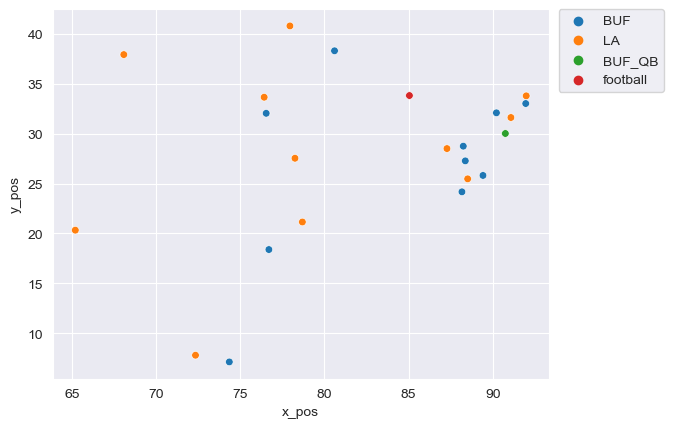

In [42]:
#get all week1_games
week1_games = week1_df['gameId'].unique()
qb_df = players_df[players_df['position']=='QB']

game_1 = week1_df[week1_df['gameId'] == week1_games[0]]

display(game_1.head(2))
print('Total number of plays in this game data: {}'.format(len(game_1.playId.unique())))
print('Number of players in this game data: {}'.format(len(game_1.nflId.unique())))

plot_data = pd.DataFrame()
play_1 = game_1[game_1['playId']==56]

play_1.to_csv('play_1.csv')

#football nflId is NaN. Should change
for player in play_1['displayName'].unique():
    #first play,frame only test
    player_data = play_1[play_1['displayName']==player]
    plot_data.loc[player,'x_pos'] = player_data['x'].iloc[0]
    plot_data.loc[player,'y_pos'] = player_data['y'].iloc[0]
    plot_data.loc[player,'team'] = player_data['club'].iloc[0]

for i in plot_data.index:
    if i in qb_df.displayName.values:
        plot_data.loc[i,'team'] = plot_data.loc[i,'team'] + '_QB'

sns.scatterplot(data=plot_data,x='x_pos',y='y_pos',hue='team',s=30)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)